# Week 4: BBC News Classification Project
## DTSA 5510 - Intro to Machine Learning - Unsupervised

In [48]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize



In [2]:
# downloads required to make this notebook run

# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')

In [3]:
# read in data
train_df = pd.read_csv('data/BBC News Train.csv')

train_df.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### EDA & cleaning:

* remove duplicate text
* remove non-alphabetical characters
  
* tfidf_vectorizer
    * remove stop words
    * lemmatize 
    * tokenize text
    * plot scores

* non-negative matrix factorization models
    * Frobenius Loss
    * Kullback-Leibler Divergence 
    * plot top words per topic
* Compare to supervised learning model

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


There are no missing values in the data.

### Cleaning:

A uniform method is needed to preprocess the text in both the training and the testing data. 

In [5]:
# function to remove duplicates
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    # number of duplicates
    number_duplicates = df['Text'].duplicated().sum()

    # print no. duplicates
    print(f'No. of duplicate articles: {number_duplicates}' '\n')

    # removal
    df_cleaned = df.drop_duplicates(subset = ['Text'])

    return df_cleaned

# function to remove non-alphabetical characters
def remove_non_alpha(text):
    
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [6]:
train_df = remove_duplicates(train_df)
train_df['Text'] = train_df['Text'].apply(remove_non_alpha)
train_df.head(5)

No. of duplicate articles: 50



,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in m payout eighteen former enron...,business


Category
sport            0.237500
business         0.232639
politics         0.184722
entertainment    0.182639
tech             0.162500
Name: count, dtype: float64 



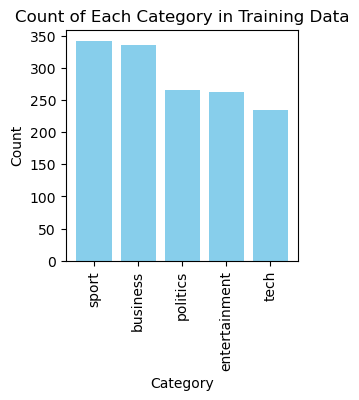

In [7]:
category_counts = train_df['Category'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

plt.figure(figsize=(3, 3))
plt.bar(category_counts.index, 
        category_counts.values, 
        color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category in Training Data')
plt.xticks(rotation=90)
plt.show()

#### Baseline model 
A baseline to compare all models against would be the dummy predictor using most frequent. If sports were the most frequently occuring topic at almost 24%, and I predicted sports as the topic for all columns, I would be correct at least around 24% of the time, assuming a representative sample.

### Vectorization:

In [8]:
text = train_df['Text']

# specify vectorizer
vectorizer = (TfidfVectorizer(max_features = 1000, 
                              stop_words='english'))

# vectorize text col
train_tfidf = vectorizer.fit_transform(train_df['Text'])

# feature names
feature_names = vectorizer.get_feature_names_out()
#print(feature_names)



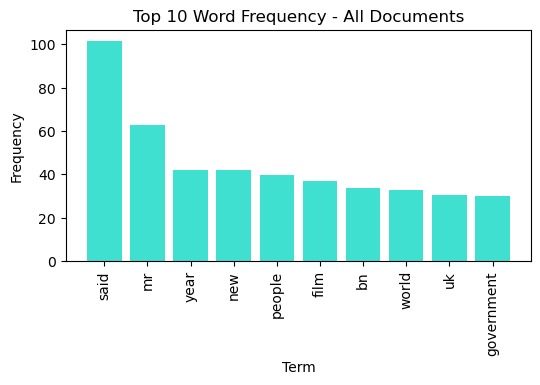

In [34]:
# word frequency - all documents
word_freq = np.sum(train_tfidf.toarray(), axis=0)
freq_all = pd.DataFrame({'Term': feature_names, 'Frequency': word_freq})
freq_all = freq_all.sort_values(by='Frequency', ascending=False)

# top 10 occurring
top_all = freq_all.head(10)

# word freq
plt.figure(figsize = (6, 3))
plt.bar(top_all['Term'], top_all['Frequency'], color='turquoise')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequency - All Documents')
plt.tick_params(axis='x', rotation=90)

plt.show()

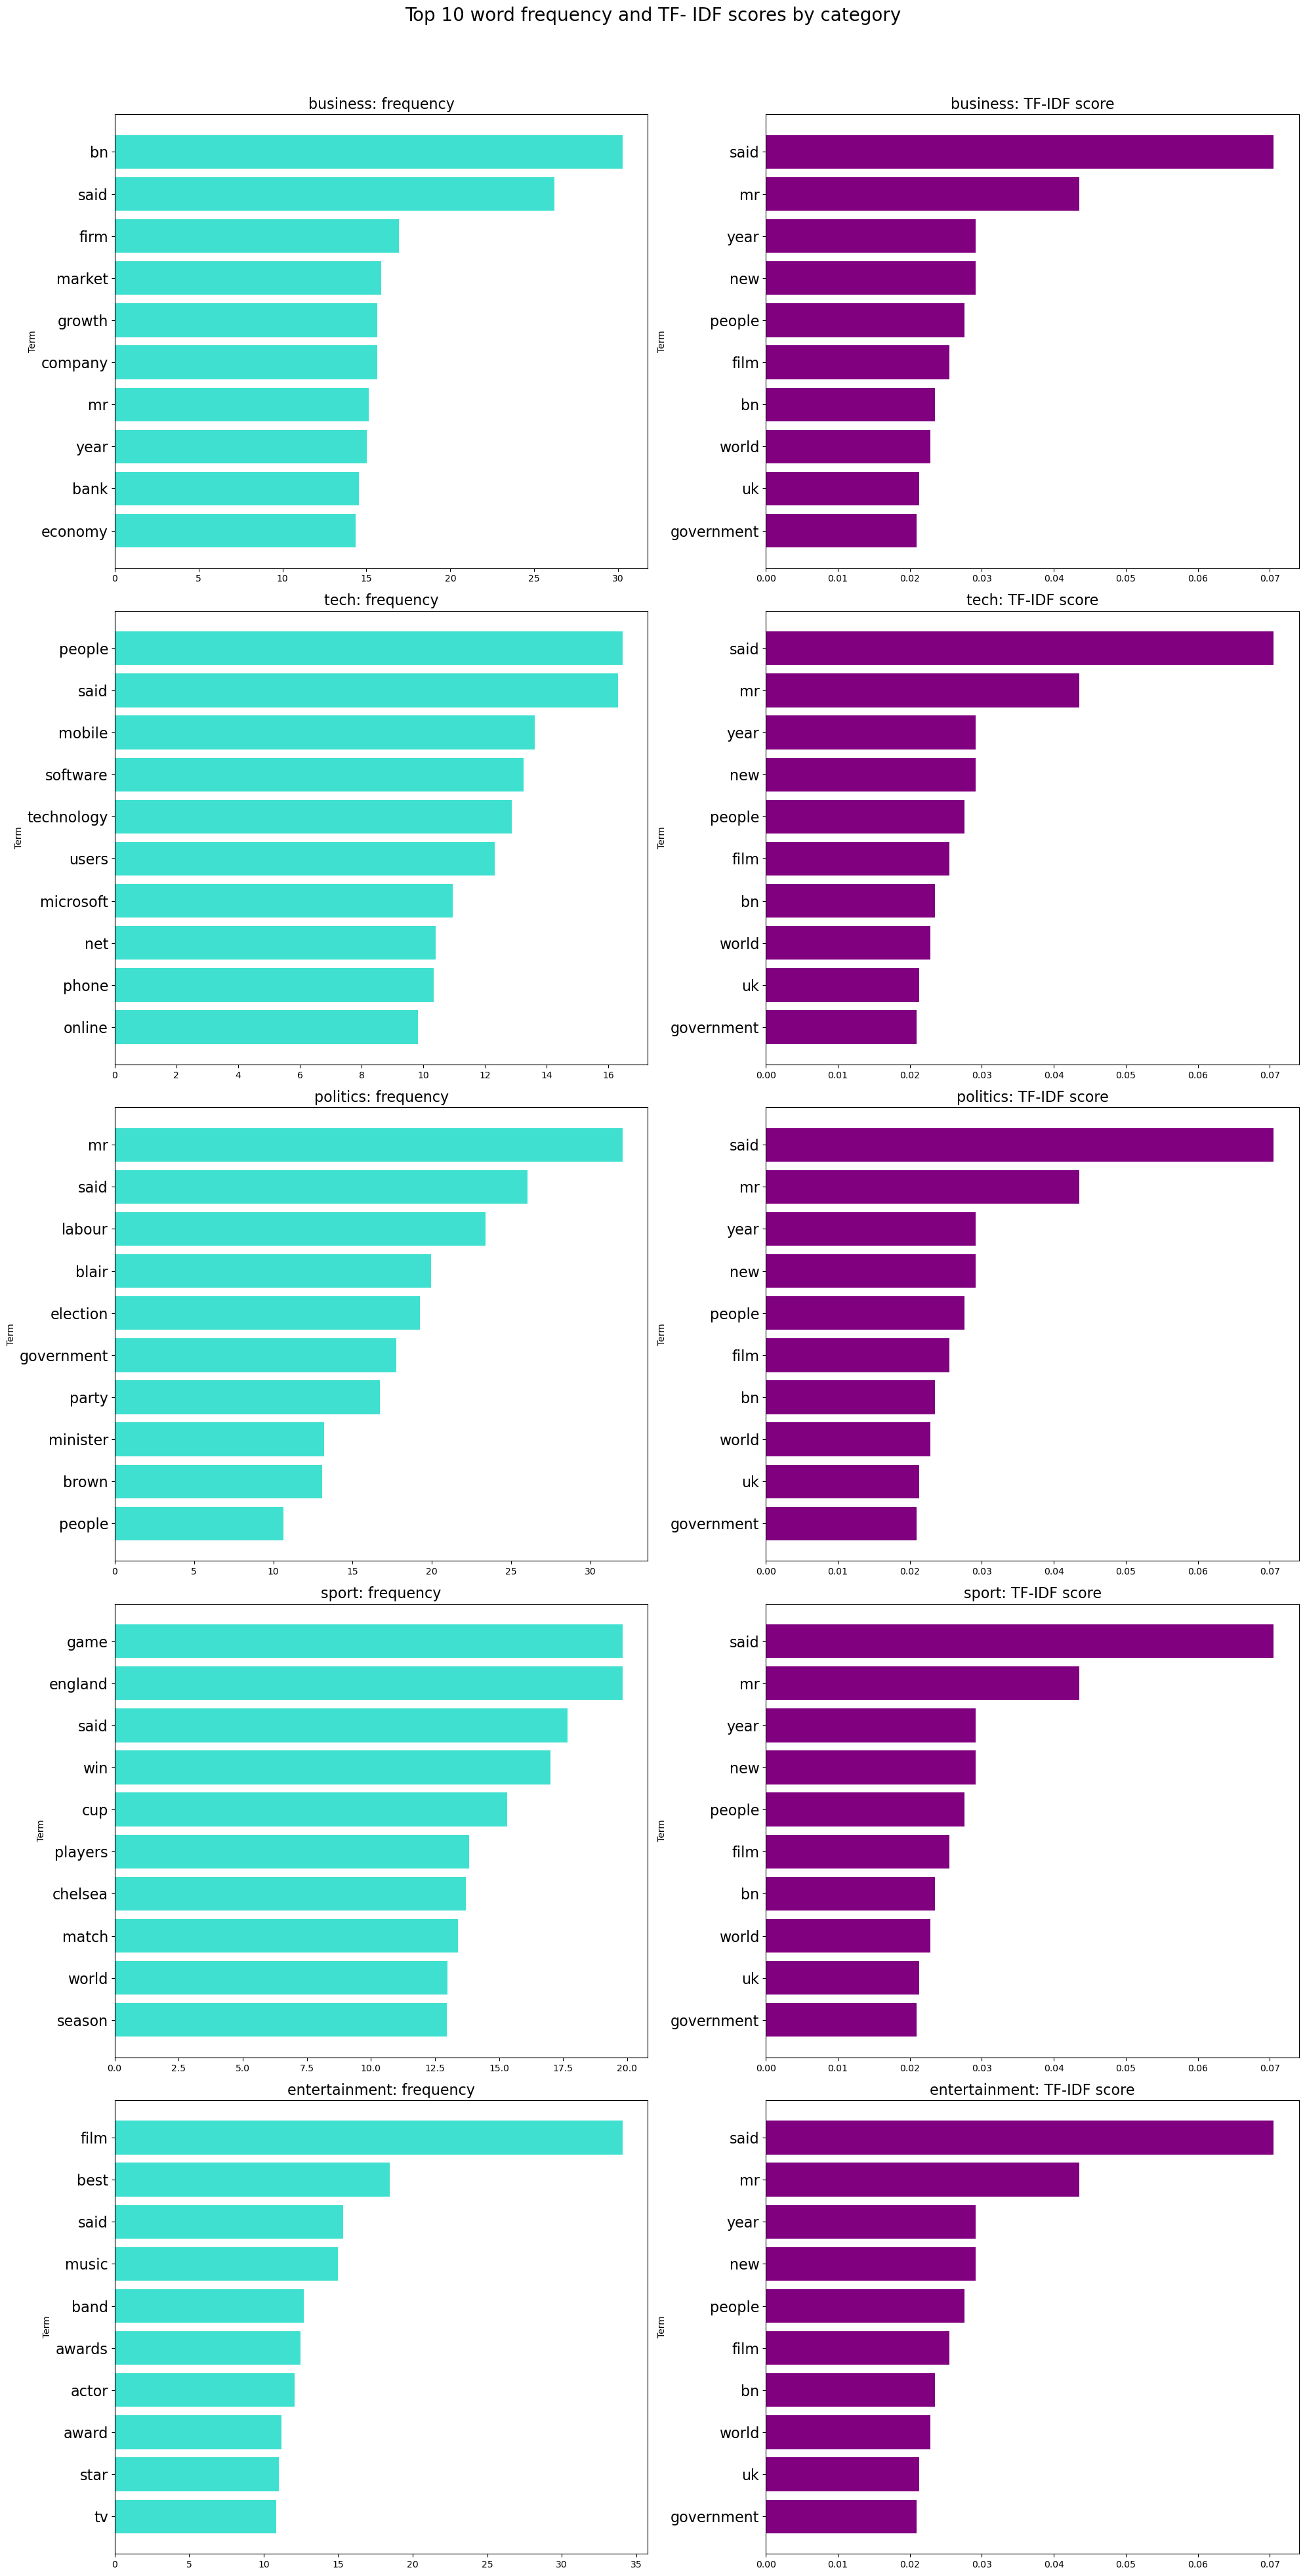

In [35]:
# subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 40))
fig.suptitle('Top 10 word frequency and TF- IDF scores by category', 
             fontsize = 20)

# word frequency - category
cat = train_df['Category'].unique()
#print(cat)

# loop to create subplots
for i, category in enumerate(cat):
    
    # filter train_tfidf for category
    cat_class = train_df['Category'] == category
    cat_tfidf = train_tfidf[cat_class]

    # word freq
    word_freq = np.sum(cat_tfidf.toarray(), 
                       axis = 0)
    freq_df = pd.DataFrame({'Term': feature_names,
                            'Frequency': word_freq})
    freq_df = freq_df.sort_values(by = 'Frequency', 
                                  ascending = False)
    # top10
    top_freq = freq_df.head(10)

    # left subplots, frequency
    ax_freq = axes[i, 0]
    ax_freq.barh(top_freq['Term'], 
           top_freq['Frequency'], 
           color='turquoise')
    ax_freq.set_title(f'{category}: frequency',
                      fontsize = 16 )
    #ax_freq.set_xlabel('Frequency')
    ax_freq.set_ylabel('Term')
    ax_freq.tick_params(axis = 'y', 
                        labelsize = 16)
    ax_freq.invert_yaxis()

    # tfidf scores
    tfidf_scores = np.mean(train_tfidf.toarray(), axis = 0)
    tfidf_all = pd.DataFrame({'Term': feature_names, 
                              'TF-IDF score': tfidf_scores})
    tfidf_all = tfidf_all.sort_values(by = 'TF-IDF score', 
                                      ascending = False)

    # top 10 scores
    top_tfidf = tfidf_all.head(10)
    
    # right subplots, scores
    ax_tfidf = axes[i, 1]
    ax_tfidf.barh(top_tfidf['Term'],
                  top_tfidf['TF-IDF score'],
                  color = 'purple')
    ax_tfidf.set_title(f'{category}: TF-IDF score', 
                       fontsize = 16)
    #ax_tfidf.set_xlabel('TF-IDF score')
    ax_tfidf.set_ylabel('Term')
    ax_tfidf.tick_params(axis = 'y', 
                         labelsize = 16)
    ax_tfidf.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### TF-IDF scores 

How important are these words in regards to the text? 
* The Tfidf scores tell us a word's importance in determining the category.(?)
* How it works: The more frequent a word is in a document or article, the less important it becomes, therefor it's frequency has an inverse relationship to it's importance. An example of this in the data is the word 'said':
        *  'Said' is in the top 10 for all 5 categories. I suspect that  
* I'll use these scores to assist in dimensionality reduction.

### Modelling with dimensionality reduction

Now that I have some TF-IDF scores, I can use that to reduce the number of dimensions in the dataframe. I've found a few options for this:

* Truncated Single Value Decomposition (TruncatedSVD) - good for large, sparse TF-IDF matrices, but does not create a non-negative representation
* Principal Component Analysis (PCA) - good for variance-based reduction, but computationally expensive to convert the data to a dense matrix
* Non-negative Matrix Factorization (NMF) - preserves the non-negative representation of the data, This is the focus of week 4 in dtsa 5510, and the method I will use for modelling and dimension reduction. As there are 3 different options for the beta loss parameter, I'll iterate through all 3 to see which provides the best results.

In [50]:
type(train_tfidf)

scipy.sparse._csr.csr_matrix

* Silhouette score does not handle a sparse matrix. I need to convert it to a dense matrix.
* Itakura-Saito beta loss does not support 0s in the matrix, so I'll create another df with a very small number added to each value.

In [64]:
category_mapping = {category: i for i, category in enumerate(train_df['Category'].unique())}
print(category_mapping)

train_labels = train_df['Category'].map(category_mapping)

train_tfidf_non_zero = train_tfidf.copy()
train_tfidf_non_zero[train_tfidf_non_zero == 0] = 1e-10

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}


C:\Users\bergs\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\bergs\miniconda3\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [66]:
# results
results_dict = {}

# beta loss options & solvers
beta_loss_solvers = {
    'frobenius': ('cd', 'nndsvd'),
    'kullback-leibler': ('mu', 'nndsvda'),
    'itakura-saito': ('mu', 'nndsvda')
}

# init nmf 
num_topics = 5  # because i know we have 5 categories

# iterate through beta loss options
for beta_loss, (solver, init) in beta_loss_solvers.items():
   
    # init nmf 
    nmf_model = NMF(n_components = num_topics, 
                    random_state = 5510, 
                    init = init,
                    beta_loss = beta_loss,
                    solver = solver
                    )
    # fit time
    start_time = time.time()
    if beta_loss == 'itakura-saito':
        # use non-zero matrix
        W = nmf_model.fit_transform(train_tfidf_non_zero)
    else:
        W = nmf_model.fit_transform(train_tfidf)
    H = nmf_model.components_
    fit_time = time.time() - start_time

    # reduce dimensions adn normalize
    reduced_df = normalize(W)
    
    # silhouette_score
    if reduced_df.shape[1] > 1:
        silhouette_avg = silhouette_score(reduced_df,
                                          train_labels)
    else:
        silhouette_avg = None

    # store results
    results_dict[beta_loss] = {
        'beta_loss_type': beta_loss,
        'solver': solver,
        'init': init,
        'mean_fit_time (s)': round(fit_time, 4),
        'silhouette_score': round(silhouette_avg, 4) if silhouette_avg is not None else 'N/A'
    }


results_df = pd.DataFrame(results_dict).T
print(results_df)


C:\Users\bergs\miniconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:886: RuntimeWarning: invalid value encountered in scalar divide
  if (previous_error - error) / error_at_init < tol:


                    beta_loss_type solver     init mean_fit_time (s)  \
frobenius                frobenius     cd   nndsvd            0.0467   
kullback-leibler  kullback-leibler     mu  nndsvda            0.4562   
itakura-saito        itakura-saito     mu  nndsvda           59.4229   

                 silhouette_score  
frobenius                   0.566  
kullback-leibler           0.6977  
itakura-saito              0.6235  


C:\Users\bergs\miniconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [67]:
results_df

,beta_loss_type,solver,init,mean_fit_time (s),silhouette_score
frobenius,frobenius,cd,nndsvd,0.0467,0.566
kullback-leibler,kullback-leibler,mu,nndsvda,0.4562,0.6977
itakura-saito,itakura-saito,mu,nndsvda,59.4229,0.6235


In [15]:
# Get feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Print top terms for each topic
num_top_words = 10  # Number of top words to display for each topic
for topic_idx, topic in enumerate(H):
    top_terms_idx = topic.argsort()[-num_top_words:][::-1]
    top_terms = [feature_names[i] for i in top_terms_idx]
    print(f"Topic {topic_idx}:")
    print(" ".join(top_terms))
    print()


Topic 0:
said growth year market economy sales firm company shares bank

Topic 1:
game england win cup said wales players team ireland play

Topic 2:
film best awards award actor actress films oscar director star

Topic 3:
mr labour blair election said brown party government minister prime

Topic 4:
people mobile music said phone technology users software use digital



In [16]:
# Assign the topic with the highest score to each document
train_df['Topic'] = W.argmax(axis=1)

# Display the first few rows with assigned topics
train_df[['ArticleId', 'Category', 'Topic']].head()


,ArticleId,Category,Topic
0,1833,business,3
1,154,business,0
2,1101,business,0
3,1976,tech,4
4,917,business,0


In [41]:
# # pipeline framework# 
# 
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.model_selection import train_test_split
# 
# # Define your unsupervised models
# models = {
#     'KMeans': KMeans(n_clusters=3, random_state=2023),
#     'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
# }
# 
# results_dict = {}
# 
# # Split your data for evaluation
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=2023)[0]
# 
# for model_name, model in models.items():
#     print(model_name, ":")
# 
#     # Create a pipeline with preprocessing and model
#     model_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('model', model)
#     ])
#     
#     # Fit the model
#     model_pipeline.fit(X_train)
# 
#     # Predict clusters
#     if hasattr(model_pipeline.named_steps['model'], 'predict'):
#         clusters = model_pipeline.named_steps['model'].predict(X_test)
#     else:
#         clusters = model_pipeline.named_steps['model'].fit_predict(X_test)
# 
#     # Evaluate using silhouette score
#     score = silhouette_score(X_test, clusters)
# 
#     # Store results
#     results_dict[model_name] = {
#         'mean_silhouette_score': round(score, 4)
#     }
# 
# results_df = pd.DataFrame(results_dict).T
# print(results_df)

## References:

1. **ChatGPT.** Damn rights, I used it and not going to pretend I didn't! I already knew the structure of pipelines and preprocessors from previous ML classes (both at UC Boulder and elsewhere). I had written out code for the tokenization and thought - why don't I incorporate this into a pipeline? That's when I turned to AI for assistance. There was a lot of back and forth, because nothing ever worked the first (or 5th) time around. AI is a tool, not a crutch. I suppose a crutch _IS_ a tool, but I digress.  **TLDR; I used AI for assistance, NOT to do the work for me.**    
      
2. [**This Kaggle notebook**](https://www.kaggle.com/code/cjtayl31772/mini-project-part-1) for guidance.

3. [**SKLearn TfidfVectorizer documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for reference.

4. [**geeksforgeeks.org**](https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/) for more guidance on TF-IDF

5. [**SKLearn NMF documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) for reference.

6. All course lectures, notebooks, examples, readings, and material etc. were heavily referenced throughout this entire notebook.